# Import Librerie

In [1]:
from pprint import pprint

# Struttura dei dati StatsBomb open-data

In questa sezione esploro la folder `open-data/data` e mostro la struttura dei JSON.


In [3]:
from pathlib import Path
import json

DATA_ROOT = Path("/Users/lorenzoguercio/Documents/Projects/sport_data/open-data/data")

# Stampa una vista sintetica della struttura della cartella dati.
def list_tree(root: Path, max_files_per_dir: int = 5):
    print(f"Root: {root}")
    if not root.exists():
        raise FileNotFoundError(f"DATA_ROOT non esiste: {root}")
    for item in sorted(root.iterdir()):
        if item.is_dir():
            files = [p.name for p in sorted(item.iterdir()) if p.is_file()]
            print(f"- {item.name}/ ({len(files)} files)")
            if files:
                preview = files[:max_files_per_dir]
                print(f"  es: {', '.join(preview)}")
        else:
            print(f"- {item.name}")

# Legge un JSON e ne riassume il tipo e le chiavi principali.
def describe_json(path: Path, max_keys: int = 20):
    if not path.exists():
        raise FileNotFoundError(f"File non trovato: {path}")
    try:
        data = json.loads(path.read_text())
    except json.JSONDecodeError as e:
        raise ValueError(f"JSON non valido in {path}: {e}") from e

    if isinstance(data, list):
        print(f"{path.name}: list (len={len(data)})")
        if data and isinstance(data[0], dict):
            keys = list(data[0].keys())
            print(f"  keys[0]: {keys[:max_keys]}")
    elif isinstance(data, dict):
        keys = list(data.keys())
        print(f"{path.name}: dict")
        print(f"  keys: {keys[:max_keys]}")
    else:
        print(f"{path.name}: {type(data).__name__}")

# Prende il primo JSON direttamente dentro una cartella.
def first_json_file(folder: Path):
    if not folder.exists():
        raise FileNotFoundError(f"Cartella non trovata: {folder}")
    files = [p for p in sorted(folder.iterdir()) if p.is_file() and p.suffix == ".json"]
    if not files:
        raise FileNotFoundError(f"Nessun JSON in: {folder}")
    return files[0]

# Gestisce matches/: scandisce le subfolder e mostra un sample per ognuna.
def describe_matches(root: Path, max_folders: int = 5):
    if not root.exists():
        raise FileNotFoundError(f"Cartella non trovata: {root}")
    folders = [p for p in sorted(root.iterdir()) if p.is_dir()]
    print(f"matches/: {len(folders)} folders")
    for folder in folders[:max_folders]:
        files = [p for p in sorted(folder.iterdir()) if p.is_file() and p.suffix == ".json"]
        print(f"- {folder.name}/ ({len(files)} files)")
        if files:
            sample = files[0]
            print(f"  sample: {sample.name}")
            describe_json(sample)

list_tree(DATA_ROOT)

# Esempi di struttura per ciascuna sottofolder

describe_json(DATA_ROOT / "competitions.json")

describe_matches(DATA_ROOT / "matches")

for sub in ["events", "lineups", "three-sixty"]:
    sample = first_json_file(DATA_ROOT / sub)
    print(f"\nSample from {sub}: {sample.name}")
    describe_json(sample)


Root: /Users/lorenzoguercio/Documents/Projects/sport_data/open-data/data
- .DS_Store
- competitions.json
- events/ (3464 files)
  es: 15946.json, 15956.json, 15973.json, 15978.json, 15986.json
- lineups/ (3464 files)
  es: 15946.json, 15956.json, 15973.json, 15978.json, 15986.json
- matches/ (0 files)
- three-sixty/ (326 files)
  es: 3788741.json, 3788742.json, 3788743.json, 3788744.json, 3788745.json
competitions.json: list (len=75)
  keys[0]: ['competition_id', 'season_id', 'country_name', 'competition_name', 'competition_gender', 'competition_youth', 'competition_international', 'season_name', 'match_updated', 'match_updated_360', 'match_available_360', 'match_available']
matches/: 21 folders
- 11/ (18 files)
  sample: 1.json
1.json: list (len=36)
  keys[0]: ['match_id', 'match_date', 'kick_off', 'competition', 'season', 'home_team', 'away_team', 'home_score', 'away_score', 'match_status', 'match_status_360', 'last_updated', 'last_updated_360', 'metadata', 'match_week', 'competition

# EDA mirata per xG (StatsBomb open-data + 360)

**Obiettivo**: stimare `P(goal | shot context + 360)`

**Output atteso**: dataset *one row per shot* + baseline model + checklist next steps.

**Scope**: *open play only* (escludo corner, punizioni, throw-in, penalty).


In [4]:
from pathlib import Path
import json
import math
import random
import pandas as pd

random.seed(42)

DATA_ROOT = Path("/Users/lorenzoguercio/Documents/Projects/sport_data/open-data/data")
EVENTS_DIR = DATA_ROOT / "events"
THREESIXTY_DIR = DATA_ROOT / "three-sixty"

OPEN_PLAY_PATTERNS = {"Regular Play", "From Counter", "From Keeper", "Other"}

def distance_to_goal(x, y, goal_x=120, goal_y=40):
    return math.hypot(goal_x - x, goal_y - y)

def shot_angle(x, y, goal_x=120, goal_y=40, goal_width=7.32):
    half_width = goal_width / 2
    left_post = (goal_x, goal_y - half_width)
    right_post = (goal_x, goal_y + half_width)
    a = math.hypot(left_post[0] - x, left_post[1] - y)
    b = math.hypot(right_post[0] - x, right_post[1] - y)
    c = goal_width
    # Legge del coseno con clipping numerico
    cos_angle = (a*a + b*b - c*c) / (2*a*b) if a > 0 and b > 0 else 1.0
    cos_angle = max(-1.0, min(1.0, cos_angle))
    return math.acos(cos_angle)

def flip_coordinates(x, y, pitch_length=120, pitch_width=80):
    return pitch_length - x, pitch_width - y

def is_open_play(event):
    play_pattern = event.get("play_pattern", {})
    return play_pattern.get("name") in OPEN_PLAY_PATTERNS


## 1) Caricamento dati e inventory

### 1.1 Load di una singola partita di test


In [5]:
# Scegli un match che abbia sia events che 360
match_ids = sorted({p.stem for p in EVENTS_DIR.glob('*.json')} & {p.stem for p in THREESIXTY_DIR.glob('*.json')})
MATCH_ID = match_ids[0] if match_ids else None
print(f"Test match_id: {MATCH_ID}")

events_path = EVENTS_DIR / f"{MATCH_ID}.json"
three_sixty_path = THREESIXTY_DIR / f"{MATCH_ID}.json"

events = json.loads(events_path.read_text())
three_sixty = json.loads(three_sixty_path.read_text())

print(f"N Events: {len(events)}")
print(f"N 360 Frames: {len(three_sixty)}")
print(f"Events Keys (sample): {list(events[0].keys())[:30]}")
print(f"360 Keys (sample): {list(three_sixty[0].keys())[:15]}")

def list_keys_by_level(obj, max_level=4):
    levels = {1: set(), 2: set(), 3: set(), 4: set()}

    def walk(o, level):
        if level > max_level:
            return
        if isinstance(o, dict):
            if level in levels:
                levels[level].update(o.keys())
            for v in o.values():
                walk(v, level + 1)
        elif isinstance(o, list):
            for item in o:
                walk(item, level)

    walk(obj, 1)
    for lvl in range(1, max_level + 1):
        keys = sorted(levels[lvl])
        print(f"LIVELLO {lvl}: {keys}")

print("\nKeys events per livello (tutti gli eventi):")
list_keys_by_level(events, max_level=4)

print("\nKeys 360 per livello (tutti i frame):")
list_keys_by_level(three_sixty, max_level=3)


Test match_id: 3788741
N Events: 3803
N 360 Frames: 3370
Events Keys (sample): ['id', 'index', 'period', 'timestamp', 'minute', 'second', 'type', 'possession', 'possession_team', 'play_pattern', 'team', 'duration', 'tactics']
360 Keys (sample): ['event_uuid', 'visible_area', 'freeze_frame']

Keys events per livello (tutti gli eventi):
LIVELLO 1: ['ball_receipt', 'ball_recovery', 'block', 'carry', 'clearance', 'counterpress', 'dribble', 'duel', 'duration', 'foul_committed', 'foul_won', 'goalkeeper', 'id', 'index', 'interception', 'location', 'minute', 'miscontrol', 'off_camera', 'out', 'pass', 'period', 'play_pattern', 'player', 'position', 'possession', 'possession_team', 'related_events', 'second', 'shot', 'substitution', 'tactics', 'team', 'timestamp', 'type', 'under_pressure']
LIVELLO 2: ['advantage', 'aerial_won', 'angle', 'assisted_shot_id', 'body_part', 'card', 'cross', 'defensive', 'deflected', 'deflection', 'end_location', 'first_time', 'formation', 'freeze_frame', 'goal_assist

In [6]:
# Chiave di collegamento events ↔ 360
print("Event id key: id")
print("360 key: event_uuid")

# Esempio di match tra i due
example_event_id = events[101].get('id')
matching_frames = [f for f in three_sixty if f.get('event_uuid') == example_event_id]
# pprint(matching_frames)
print(f"Esempio event id: {example_event_id}")
print(f"Frames 360 che matchano: {len(matching_frames)}")


Event id key: id
360 key: event_uuid
Esempio event id: 30b3496b-e595-45c3-b28a-fed88dff7fc1
Frames 360 che matchano: 1


### 1.2 Data coverage
Decisione: usare 360 solo quando presente oppure filtrare a sole partite con 360.


In [7]:
event_ids = {p.stem for p in EVENTS_DIR.glob('*.json')}
three_sixty_ids = {p.stem for p in THREESIXTY_DIR.glob('*.json')}

matches_with_360 = sorted(event_ids & three_sixty_ids)
print(f"matches con 360: {len(matches_with_360)} / {len(event_ids)}")

total_events = 0
total_frames = 0
total_events_with_360 = 0
total_shots = 0
total_shots_with_360 = 0

invalid_360 = []

for mid in matches_with_360:
    ev = json.loads((EVENTS_DIR / f"{mid}.json").read_text())
    th_path = THREESIXTY_DIR / f"{mid}.json"
    try:
        th_text = th_path.read_text()
        th = json.loads(th_text)
    except json.JSONDecodeError as e:
        invalid_360.append({
            "match_id": mid,
            "path": str(th_path),
            "error": str(e),
            "size": th_path.stat().st_size if th_path.exists() else None,
        })
        continue

    total_events += len(ev)
    total_frames += len(th)
    th_event_ids = {f.get('event_uuid') for f in th}
    total_events_with_360 += sum(1 for e in ev if e.get('id') in th_event_ids)
    shots = [e for e in ev if e.get('type', {}).get('name') == 'Shot']
    total_shots += len(shots)
    total_shots_with_360 += sum(1 for s in shots if s.get('id') in th_event_ids)

event_coverage = total_events_with_360 / total_events if total_events else 0
shot_coverage = total_shots_with_360 / total_shots if total_shots else 0

print(f"% eventi con 360 (solo match con 360): {event_coverage:.2%}")
print(f"% shot con 360 (solo match con 360): {shot_coverage:.2%}")

if invalid_360:
    print(f"File 360 non validi: {len(invalid_360)}")
    for item in invalid_360[:10]:
        print(f"- {item['match_id']}: {item['path']} | {item['error']} | size={item['size']}")


matches con 360: 326 / 3464
% eventi con 360 (solo match con 360): 87.10%
% shot con 360 (solo match con 360): 96.49%
File 360 non validi: 3
- 3835338: /Users/lorenzoguercio/Documents/Projects/sport_data/open-data/data/three-sixty/3835338.json | Expecting value: line 181321 column 20 (char 5193728) | size=5959607
- 3835342: /Users/lorenzoguercio/Documents/Projects/sport_data/open-data/data/three-sixty/3835342.json | Expecting ',' delimiter: line 171856 column 109 (char 4882432) | size=5942292
- 3845506: /Users/lorenzoguercio/Documents/Projects/sport_data/open-data/data/three-sixty/3845506.json | Expecting ',' delimiter: line 92794 column 3 (char 2637824) | size=6260494


In [8]:
# Lista completa dei play_pattern presenti (match con 360)
play_patterns = set()
for mid in matches_with_360:
    ev = json.loads((EVENTS_DIR / f"{mid}.json").read_text())
    for e in ev:
        name = e.get('play_pattern', {}).get('name')
        if name:
            play_patterns.add(name)

print(sorted(play_patterns))


['From Corner', 'From Counter', 'From Free Kick', 'From Goal Kick', 'From Keeper', 'From Kick Off', 'From Throw In', 'Other', 'Regular Play']


### 1.3 Validazione join events ↔ 360
Output: tabella di join quality (match rate, missing, duplicates).


In [9]:
ev_ids = [e.get('id') for e in events]
th_ids = [f.get('event_uuid') for f in three_sixty]

ev_set = set(ev_ids)
th_set = set(th_ids)

match_rate = len(ev_set & th_set) / len(ev_set) if ev_set else 0
missing_in_360 = len(ev_set - th_set)
missing_in_events = len(th_set - ev_set)
duplicates = len(th_ids) - len(th_set)

join_quality = pd.DataFrame([
    {
        'match_id': MATCH_ID,
        'match_rate': match_rate,
        'events_missing_360': missing_in_360,
        'frames_missing_event': missing_in_events,
        'duplicate_360_event_uuid': duplicates,
    }
])
join_quality


,match_id,match_rate,events_missing_360,frames_missing_event,duplicate_360_event_uuid
0,3788741,0.886143,433,0,0


# 2) Definizione del target e shot universe (open play)

In questa sezione considero solo **open play**. Penalty e free kick vengono esclusi.


In [10]:
# 2.1 Estrazione Shot (open play): singolo match + full dataset
# Singola partita di test (già caricata in 1.1)
shots_match = [e for e in events if e.get('type', {}).get('name') == 'Shot']

def shot_outcome_is_goal(shot_event):
    outcome = shot_event.get('shot', {}).get('outcome', {})
    return outcome.get('name') == 'Goal'

def shot_type_name(shot_event):
    return shot_event.get('shot', {}).get('type', {}).get('name')

open_play_shots_match = [s for s in shots_match if is_open_play(s)]
open_play_shots_match = [s for s in open_play_shots_match if shot_type_name(s) not in {"Penalty", "Free Kick"}]

print(f"shots totali (singolo match): {len(shots_match)}")
print(f"shots open play (singolo match): {len(open_play_shots_match)}")
y_match = [1 if shot_outcome_is_goal(s) else 0 for s in open_play_shots_match]
print(f"goal rate (open play, singolo match): {sum(y_match)/len(y_match) if y_match else 0:.2%}")


shots totali (singolo match): 27
shots open play (singolo match): 6
goal rate (open play, singolo match): 16.67%


In [11]:
# Full dataset: tutti i match con 360
# Riutilizzo matches_with_360 calcolato nella sezione 1.2
all_events = []
for mid in matches_with_360:
    ev_path = EVENTS_DIR / f"{mid}.json"
    all_events.extend(json.loads(ev_path.read_text()))

shots = [e for e in all_events if e.get('type', {}).get('name') == 'Shot']
open_play_shots = [s for s in shots if is_open_play(s)]
open_play_shots = [s for s in open_play_shots if shot_type_name(s) not in {"Penalty", "Free Kick"}]

print(f"shots totali (match con 360): {len(shots)}")
print(f"shots open play (match con 360): {len(open_play_shots)}")
y = [1 if shot_outcome_is_goal(s) else 0 for s in open_play_shots]
print(f"goal rate (open play, match con 360): {sum(y)/len(y) if y else 0:.2%}")

shots totali (match con 360): 8512
shots open play (match con 360): 3290
goal rate (open play, match con 360): 10.36%


In [12]:
# 2.2 Distribuzione del target (open play)
# Aggrego su tutti i match con 360
def rate_by(key_fn):
    buckets = {}
    for s in open_play_shots:
        key = key_fn(s) or 'Unknown'
        if key not in buckets:
            buckets[key] = {"n": 0, "g": 0}
        buckets[key]["n"] += 1
        buckets[key]["g"] += 1 if shot_outcome_is_goal(s) else 0
    rows = []
    for k, v in buckets.items():
        rows.append({"group": k, "shots": v["n"], "goal_rate": v["g"]/v["n"] if v["n"] else 0})
    return pd.DataFrame(rows).sort_values(by='shots', ascending=False)

by_shot_type = rate_by(lambda s: s.get('shot', {}).get('type', {}).get('name'))
by_body_part = rate_by(lambda s: s.get('shot', {}).get('body_part', {}).get('name'))
by_play_pattern = rate_by(lambda s: s.get('play_pattern', {}).get('name'))

print("Goal rate per shot.type (open play):")
display(by_shot_type.head(10))
print("Goal rate per body_part (open play):")
display(by_body_part.head(10))
print("Goal rate per play_pattern (open play):")
display(by_play_pattern.head(10))


Goal rate per shot.type (open play):


,group,shots,goal_rate
0,Open Play,3290,0.103647


Goal rate per body_part (open play):


,group,shots,goal_rate
1,Right Foot,1880,0.095745
0,Left Foot,1079,0.102873
2,Head,319,0.150470
3,Other,12,0.166667


Goal rate per play_pattern (open play):


,group,shots,goal_rate
0,Regular Play,2750,0.097091
1,From Counter,370,0.132432
3,From Keeper,143,0.125874
2,Other,27,0.259259


# 3) Feature base geometriche (must-have)

Questa sezione costruisce le feature geometriche minime e verifica la coerenza delle coordinate.


In [13]:
# 3.1 Coordinate sanity + flipping
# Controllo range coordinate per gli shot open play (match con 360)
shot_locs = [s.get('location') for s in open_play_shots if isinstance(s.get('location'), list)]
xs = [loc[0] for loc in shot_locs] if shot_locs else []
ys = [loc[1] for loc in shot_locs] if shot_locs else []

print(f"x in range [0,120]: {all(0 <= x <= 120 for x in xs)}")
print(f"y in range [0,80]: {all(0 <= y <= 80 for y in ys)}")

# Flip: porta sempre a destra (x crescente)
def flip_shot_location(loc):
    if not isinstance(loc, list) or len(loc) < 2:
        return None
    x, y = loc[0], loc[1]
    # Se il tiro e' verso la sinistra (x < 60), flippa
    return (120 - x, 80 - y) if x < 60 else (x, y)

flipped = [flip_shot_location(loc) for loc in shot_locs]
flipped = [f for f in flipped if f is not None]

# Controllo visivo rapido: stampa i primi 5 punti flippati
print("Esempio location flippate:", flipped[:5])


x in range [0,120]: True
y in range [0,80]: True
Esempio location flippate: [(98.9, 58.7), (87.0, 53.6), (111.2, 27.2), (111.7, 30.9), (107.9, 29.5)]


In [14]:
# 3.2 Distanza & angolo
# Calcolo delle feature geometriche sugli shot open play
def shot_distance_angle(shot_event):
    loc = shot_event.get('location')
    if not isinstance(loc, list) or len(loc) < 2:
        return None, None
    x, y = loc[0], loc[1]
    # Porta a destra per coerenza
    if x < 60:
        x, y = flip_coordinates(x, y)
    return distance_to_goal(x, y), shot_angle(x, y)

distances = []
angles = []
for s in open_play_shots:
    d, a = shot_distance_angle(s)
    if d is not None and a is not None:
        distances.append(d)
        angles.append(a)

print(f"distanze calcolate: {len(distances)}")
print(f"angoli calcolati: {len(angles)}")

# Binning semplice per goal rate vs distanza/angolo
df_geom = pd.DataFrame({
    'distance': distances,
    'angle': angles,
    'goal': [1 if shot_outcome_is_goal(s) else 0 for s in open_play_shots if s.get('location')],
})

df_geom['dist_bin'] = pd.cut(df_geom['distance'], bins=10)
df_geom['angle_bin'] = pd.cut(df_geom['angle'], bins=10)

# print("Goal rate vs distanza (binning):")
# display(df_geom.groupby('dist_bin')['goal'].mean().reset_index())
# print("Goal rate vs angolo (binning):")
# display(df_geom.groupby('angle_bin')['goal'].mean().reset_index())


distanze calcolate: 3290
angoli calcolati: 3290


/var/folders/gl/8sp6_b_15m58yt5jq8bzjpjr0000gn/T/ipykernel_15325/2931163590.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_dist = df_geom.groupby('dist_bin').agg(goal_rate=('goal', 'mean'), shots=('goal', 'size')).reset_index()


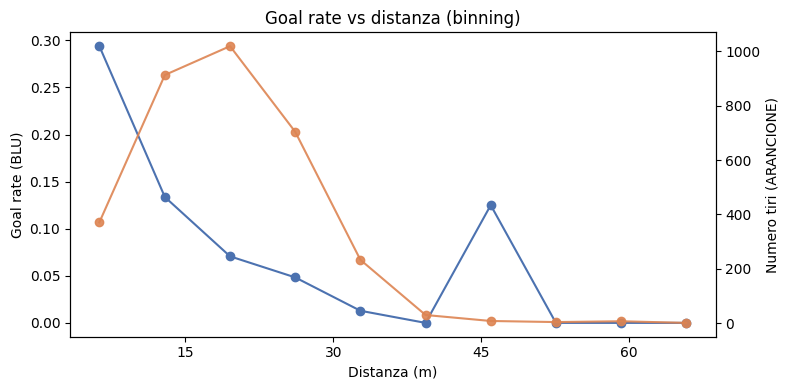

/var/folders/gl/8sp6_b_15m58yt5jq8bzjpjr0000gn/T/ipykernel_15325/2931163590.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_angle = df_geom.groupby('angle_bin').agg(goal_rate=('goal', 'mean'), shots=('goal', 'size')).reset_index()


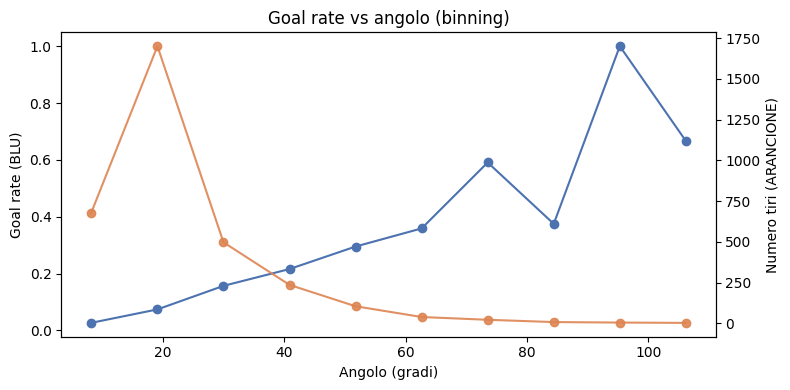

In [15]:
# Visualizzazione: goal rate + numero tiri per bin (assi continui)
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import math

# Distanza
agg_dist = df_geom.groupby('dist_bin').agg(goal_rate=('goal', 'mean'), shots=('goal', 'size')).reset_index()
agg_dist['bin_center'] = agg_dist['dist_bin'].apply(lambda x: (x.left + x.right) / 2)
agg_dist = agg_dist.sort_values('bin_center')

fig, ax1 = plt.subplots(figsize=(8, 4))
ax2 = ax1.twinx()

# Linea continua per goal rate
ax1.plot(agg_dist['bin_center'], agg_dist['goal_rate'], color='#4C72B0', marker='o')
ax1.set_title('Goal rate vs distanza (binning)')
ax1.set_xlabel('Distanza (m)')
ax1.set_ylabel('Goal rate (BLU)')
ax1.xaxis.set_major_locator(MaxNLocator(6))

# Linea per numero tiri
ax2.plot(agg_dist['bin_center'], agg_dist['shots'], color='#DD8452', marker='o', alpha=0.9)
ax2.set_ylabel('Numero tiri (ARANCIONE)')

plt.tight_layout()
plt.show()

# Angolo (convertito in gradi per leggibilità)
agg_angle = df_geom.groupby('angle_bin').agg(goal_rate=('goal', 'mean'), shots=('goal', 'size')).reset_index()
agg_angle['bin_center_rad'] = agg_angle['angle_bin'].apply(lambda x: (x.left + x.right) / 2)
agg_angle['bin_center_deg'] = agg_angle['bin_center_rad'].apply(math.degrees)
agg_angle = agg_angle.sort_values('bin_center_deg')

fig, ax1 = plt.subplots(figsize=(8, 4))
ax2 = ax1.twinx()

ax1.plot(agg_angle['bin_center_deg'], agg_angle['goal_rate'], color='#4C72B0', marker='o')
ax1.set_title('Goal rate vs angolo (binning)')
ax1.set_xlabel('Angolo (gradi)')
ax1.set_ylabel('Goal rate (BLU)')
ax1.xaxis.set_major_locator(MaxNLocator(6))

ax2.plot(agg_angle['bin_center_deg'], agg_angle['shots'], color='#DD8452', marker='o', alpha=0.9)
ax2.set_ylabel('Numero tiri (ARANCIONE)')

plt.tight_layout()
plt.show()


In [16]:
# 3.3 Shot metadata e missingness
# Verifico quali campi sono presenti e quanto sono completi
meta_fields = [
    ('body_part', lambda s: s.get('shot', {}).get('body_part', {}).get('name')),
    ('first_time', lambda s: s.get('shot', {}).get('first_time')),
    ('one_on_one', lambda s: s.get('shot', {}).get('one_on_one')),
    ('open_goal', lambda s: s.get('shot', {}).get('open_goal')),
    ('under_pressure', lambda s: s.get('under_pressure')),
]

rows = []
for name, fn in meta_fields:
    values = [fn(s) for s in open_play_shots]
    present = sum(v is not None for v in values)
    rows.append({
        'feature': name,
        'present': present,
        'missing': len(values) - present,
        'coverage': present / len(values) if values else 0,
    })

missingness = pd.DataFrame(rows).sort_values(by='coverage', ascending=False)
display(missingness)

always_available = missingness[missingness['coverage'] >= 0.95]['feature'].tolist()
sparse = missingness[missingness['coverage'] < 0.5]['feature'].tolist()
print(f"Feature sempre disponibili: {always_available}")
print(f"Feature sparse/rare: {sparse}")


,feature,present,missing,coverage
0,body_part,3290,0,1.000000
1,first_time,1080,2210,0.328267
4,under_pressure,841,2449,0.255623
2,one_on_one,146,3144,0.044377
3,open_goal,30,3260,0.009119


Feature sempre disponibili: ['body_part']
Feature sparse/rare: ['first_time', 'under_pressure', 'one_on_one', 'open_goal']


# 4) EDA specifica per 360 (freeze frame)

Questa sezione analizza la struttura dei freeze_frame e la loro copertura.


In [17]:
# 4.1 Cos'e' nel freeze_frame
# Uso i frame 360 del match di test (three_sixty) e poi aggrego su tutti i match con 360

def freeze_frame_stats(frames):
    total_frames = len(frames)
    n_players = []
    keeper_present = 0
    teammate_count = []
    opponent_count = []
    actor_ok = 0

    for f in frames:
        ff = f.get('freeze_frame') or []
        n_players.append(len(ff))

        # keeper: almeno un player con keeper == True
        if any(p.get('keeper') for p in ff):
            keeper_present += 1

        # teammate vs opponent
        teammate_count.append(sum(1 for p in ff if p.get('teammate') is True))
        opponent_count.append(sum(1 for p in ff if p.get('teammate') is False))

        # actor: uno e uno solo
        if sum(1 for p in ff if p.get('actor') is True) == 1:
            actor_ok += 1

    return {
        'frames': total_frames,
        'avg_players': sum(n_players) / total_frames if total_frames else 0,
        'keeper_rate': keeper_present / total_frames if total_frames else 0,
        'avg_teammates': sum(teammate_count) / total_frames if total_frames else 0,
        'avg_opponents': sum(opponent_count) / total_frames if total_frames else 0,
        'actor_ok_rate': actor_ok / total_frames if total_frames else 0,
    }

# Statistiche sul match di test
stats_test = freeze_frame_stats(three_sixty)
print('Match test:', stats_test)

# Statistiche su tutti i match con 360 (con debug JSON)
all_frames = []
invalid_360 = []
for mid in matches_with_360:
    th_path = THREESIXTY_DIR / f"{mid}.json"
    try:
        frames = json.loads(th_path.read_text())
    except json.JSONDecodeError as e:
        invalid_360.append({
            'match_id': mid,
            'path': str(th_path),
            'error': str(e),
            'size': th_path.stat().st_size if th_path.exists() else None,
        })
        continue
    all_frames.extend(frames)

stats_all = freeze_frame_stats(all_frames)
print('All matches:', stats_all)

if invalid_360:
    print(f"File 360 non validi: {len(invalid_360)}")
    for item in invalid_360[:10]:
        print(f"- {item['match_id']}: {item['path']} | {item['error']} | size={item['size']}")


Match test: {'frames': 3370, 'avg_players': 13.571810089020772, 'keeper_rate': 0.2605341246290801, 'avg_teammates': 6.82106824925816, 'avg_opponents': 6.750741839762611, 'actor_ok_rate': 1.0}
All matches: {'frames': 1027908, 'avg_players': 15.160928799075403, 'keeper_rate': 0.34352879829712385, 'avg_teammates': 7.575464924876545, 'avg_opponents': 7.585463874198858, 'actor_ok_rate': 0.9999854072543457}
File 360 non validi: 3
- 3835338: /Users/lorenzoguercio/Documents/Projects/sport_data/open-data/data/three-sixty/3835338.json | Expecting value: line 181321 column 20 (char 5193728) | size=5959607
- 3835342: /Users/lorenzoguercio/Documents/Projects/sport_data/open-data/data/three-sixty/3835342.json | Expecting ',' delimiter: line 171856 column 109 (char 4882432) | size=5942292
- 3845506: /Users/lorenzoguercio/Documents/Projects/sport_data/open-data/data/three-sixty/3845506.json | Expecting ',' delimiter: line 92794 column 3 (char 2637824) | size=6260494


**Decisione:** se il keeper manca spesso, usare fallback (NaN + indicatore di missing).


**Decisioni (open play):**
- I rigori non entrano nel dataset principale (trattati separatamente).
- I free kick non entrano nel dataset principale.
- Modello unico per open play; `shot.type` resta come feature.


## 4.2 Feature 360 semplici e forti

In questa sezione costruiamo feature 360 per ogni shot con freeze_frame e valutiamo segnale e ridondanza.


In [18]:
# Join base events + 360 (indice frame 360)
# Creo un dizionario event_id -> frame 360 per join veloce

import math

# Helper geometria
GOAL_X = 120
GOAL_Y = 40
GOAL_WIDTH = 7.32
LEFT_POST = (GOAL_X, GOAL_Y - GOAL_WIDTH / 2)
RIGHT_POST = (GOAL_X, GOAL_Y + GOAL_WIDTH / 2)


def polygon_area(coords):
    # Shoelace formula per area poligono
    if not coords or len(coords) < 3:
        return None
    area = 0.0
    for i in range(len(coords)):
        x1, y1 = coords[i]
        x2, y2 = coords[(i + 1) % len(coords)]
        area += x1 * y2 - x2 * y1
    return abs(area) / 2


def point_in_triangle(pt, a, b, c):
    # Barycentric method
    px, py = pt
    ax, ay = a
    bx, by = b
    cx, cy = c

    v0x, v0y = cx - ax, cy - ay
    v1x, v1y = bx - ax, by - ay
    v2x, v2y = px - ax, py - ay

    dot00 = v0x * v0x + v0y * v0y
    dot01 = v0x * v1x + v0y * v1y
    dot02 = v0x * v2x + v0y * v2y
    dot11 = v1x * v1x + v1y * v1y
    dot12 = v1x * v2x + v1y * v2y

    denom = dot00 * dot11 - dot01 * dot01
    if denom == 0:
        return False
    inv = 1 / denom
    u = (dot11 * dot02 - dot01 * dot12) * inv
    v = (dot00 * dot12 - dot01 * dot02) * inv
    return (u >= 0) and (v >= 0) and (u + v <= 1)


def dist(a, b):
    return math.hypot(a[0] - b[0], a[1] - b[1])


# Indicizza i frame 360 per event_uuid (con gestione di JSON invalidi)
frames_by_event = {}
invalid_360 = []
for mid in matches_with_360:
    th_path = THREESIXTY_DIR / f"{mid}.json"
    try:
        frames = json.loads(th_path.read_text())
    except json.JSONDecodeError as e:
        invalid_360.append({
            'match_id': mid,
            'path': str(th_path),
            'error': str(e),
        })
        continue

    for f in frames:
        event_id = f.get('event_uuid')
        if event_id:
            frames_by_event[event_id] = f

print(f"Frame indicizzati: {len(frames_by_event)}")
if invalid_360:
    print(f"File 360 non validi: {len(invalid_360)}")


Frame indicizzati: 1027908
File 360 non validi: 3


**Join base events ↔ 360**

Qui costruiamo il dataset `shots_360`: per ogni shot open play, aggancio il relativo `freeze_frame` usando `event_id` ↔ `event_uuid`.


In [19]:
# Join base events + 360 (costruzione shots_360)
# Costruisco il dataset base: uno shot per riga con frame 360 associato

shots_360_rows = []
for mid in matches_with_360:
    ev = json.loads((EVENTS_DIR / f"{mid}.json").read_text())
    for e in ev:
        # Solo eventi Shot
        if e.get('type', {}).get('name') != 'Shot':
            continue
        # Applica filtro open play
        if not is_open_play(e):
            continue
        # Escludi penalty/free kick
        if e.get('shot', {}).get('type', {}).get('name') in {'Penalty', 'Free Kick'}:
            continue

        # Join: event_id (events) -> event_uuid (360)
        event_id = e.get('id')
        frame = frames_by_event.get(event_id)
        if not frame:
            continue

        # Location del tiro (x,y)
        loc = e.get('location') or []
        if len(loc) < 2:
            continue

        shots_360_rows.append({
            'match_id': mid,
            'event_id': event_id,
            'shot_x': loc[0],
            'shot_y': loc[1],
            'goal': 1 if shot_outcome_is_goal(e) else 0,
            'distance': distance_to_goal(*loc),
            'angle': shot_angle(*loc),
            'frame': frame,
        })

shots_360 = pd.DataFrame(shots_360_rows)
print(f"shots_360: {len(shots_360)}")
shots_360.head()


shots_360: 3159


,match_id,event_id,shot_x,shot_y,goal,distance,angle,frame
0,3788741,188ed7fe-c5c0-45f3-9127-e51b05ed8dc9,98.9,58.7,0,28.193971,0.195120,{'event_uuid': '188ed7fe-c5c0-45f3-9127-e51b05...
1,3788741,910f8682-7328-436e-aff8-e508c9f6da7a,87.0,53.6,0,35.692576,0.189333,{'event_uuid': '910f8682-7328-436e-aff8-e508c9...
2,3788741,d91b87fb-6955-4b54-99bd-125f0206df24,111.2,27.2,0,15.533190,0.275483,{'event_uuid': 'd91b87fb-6955-4b54-99bd-125f02...
3,3788741,882d229d-aaf0-4b55-a601-3776fedb67f9,111.7,30.9,0,12.316655,0.413913,{'event_uuid': '882d229d-aaf0-4b55-a601-3776fe...
4,3788741,ead96180-5c0c-4ccb-b926-d215ba883fcb,107.9,29.5,1,16.020612,0.349178,{'event_uuid': 'ead96180-5c0c-4ccb-b926-d215ba...


In [20]:
# Estrazione feature 360 per ogni shot

# Estrae feature 360 dalla freeze_frame associata allo shot
def extract_360_features(row):
    frame = row['frame']
    ff = frame.get('freeze_frame') or []
    shot_pt = (row['shot_x'], row['shot_y'])

    # Separa avversari e keeper
    opponents = [p for p in ff if p.get('teammate') is False]
    keepers = [p for p in ff if p.get('keeper') is True]

    # Nearest defender distance
    # Coordinate avversari in freeze_frame
    opp_locs = [p.get('location') for p in opponents if isinstance(p.get('location'), list)]
    # Coordinate avversari in freeze_frame
    opp_locs = [(p[0], p[1]) for p in opp_locs if len(p) >= 2]
    # Distanza del difensore piu vicino
    nearest_def_dist = min([dist(shot_pt, p) for p in opp_locs], default=None)

    # Keeper distances
    # Distanza del keeper da tiro e porta
    keeper_loc = None
    if keepers:
        loc = keepers[0].get('location')
        if isinstance(loc, list) and len(loc) >= 2:
    # Distanza del keeper da tiro e porta
            keeper_loc = (loc[0], loc[1])
    keeper_dist_to_shot = dist(shot_pt, keeper_loc) if keeper_loc else None
    keeper_dist_to_goal = dist((GOAL_X, GOAL_Y), keeper_loc) if keeper_loc else None

    # Defenders within 1m/2m/3m
    # Conteggi pressione locale entro raggio
    def within(radius):
        return sum(1 for p in opp_locs if dist(shot_pt, p) <= radius)

    n_def_1m = within(1)
    n_def_2m = within(2)
    n_def_3m = within(3)

    # Players in cone to goal (triangolo: palla + pali)
    # Avversari nel triangolo palla-pali
    cone_count = sum(1 for p in opp_locs if point_in_triangle(p, shot_pt, LEFT_POST, RIGHT_POST))

    # Visible area size (poligono)
    # Area visibile (se disponibile)
    visible_area = frame.get('visible_area')
    va_size = None
    if isinstance(visible_area, list):
        va_coords = [(visible_area[i], visible_area[i + 1]) for i in range(0, len(visible_area), 2)]
        va_size = polygon_area(va_coords)

    return pd.Series({
        'nearest_defender_dist': nearest_def_dist,
        'keeper_dist_to_shot': keeper_dist_to_shot,
        'keeper_dist_to_goal': keeper_dist_to_goal,
        'n_defenders_within_1m': n_def_1m,
        'n_defenders_within_2m': n_def_2m,
        'n_defenders_within_3m': n_def_3m,
        'n_players_in_cone_to_goal': cone_count,
        'visible_area_size': va_size,
    })

features_360 = shots_360.apply(extract_360_features, axis=1)
shots_360 = pd.concat([shots_360.drop(columns=['frame']), features_360], axis=1)
shots_360.head()


,match_id,event_id,shot_x,shot_y,goal,distance,angle,nearest_defender_dist,keeper_dist_to_shot,keeper_dist_to_goal,n_defenders_within_1m,n_defenders_within_2m,n_defenders_within_3m,n_players_in_cone_to_goal,visible_area_size
0,3788741,188ed7fe-c5c0-45f3-9127-e51b05ed8dc9,98.9,58.7,0,28.193971,0.195120,4.547446,NaN,NaN,0.0,0.0,0.0,0.0,1905.799690
1,3788741,910f8682-7328-436e-aff8-e508c9f6da7a,87.0,53.6,0,35.692576,0.189333,1.205218,NaN,NaN,0.0,1.0,1.0,0.0,2400.347256
2,3788741,d91b87fb-6955-4b54-99bd-125f0206df24,111.2,27.2,0,15.533190,0.275483,1.244280,10.772498,4.765918,0.0,1.0,1.0,1.0,1519.032280
3,3788741,882d229d-aaf0-4b55-a601-3776fedb67f9,111.7,30.9,0,12.316655,0.413913,0.692878,9.500729,2.820999,1.0,1.0,1.0,2.0,1092.767543
4,3788741,ead96180-5c0c-4ccb-b926-d215ba883fcb,107.9,29.5,1,16.020612,0.349178,8.265755,12.052522,3.968668,0.0,0.0,0.0,1.0,1691.402960


In [21]:
# Distribuzioni e goal rate per bins (feature 360)

feature_cols = [
    'nearest_defender_dist',
    'keeper_dist_to_shot',
    'keeper_dist_to_goal',
    'n_defenders_within_1m',
    'n_defenders_within_2m',
    'n_defenders_within_3m',
    'n_players_in_cone_to_goal',
    'visible_area_size',
]

# Loop su feature: distribuzione e goal rate per bin
for col in feature_cols:
    series = shots_360[col].dropna()
    if series.empty:
        print(f"{col}: nessun dato")
        continue

    # Bin automatici (10) per una lettura veloce
    bins = pd.cut(series, bins=10)
    tmp = shots_360.loc[series.index].copy()
    tmp['bin'] = bins
    grouped = tmp.groupby('bin')['goal'].mean().reset_index()

    print(f"{col} - distribuzione e goal rate")
    display(grouped)


nearest_defender_dist - distribuzione e goal rate


/var/folders/gl/8sp6_b_15m58yt5jq8bzjpjr0000gn/T/ipykernel_15325/2235882757.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = tmp.groupby('bin')['goal'].mean().reset_index()


,bin,goal
0,"(0.0577, 1.233]",0.092006
1,"(1.233, 2.396]",0.102914
2,"(2.396, 3.56]",0.117730
3,"(3.56, 4.723]",0.124260
4,"(4.723, 5.886]",0.092683
5,"(5.886, 7.05]",0.059524
6,"(7.05, 8.213]",0.153846
7,"(8.213, 9.377]",0.095238
8,"(9.377, 10.54]",0.000000
9,"(10.54, 11.703]",0.000000


keeper_dist_to_shot - distribuzione e goal rate


/var/folders/gl/8sp6_b_15m58yt5jq8bzjpjr0000gn/T/ipykernel_15325/2235882757.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = tmp.groupby('bin')['goal'].mean().reset_index()


,bin,goal
0,"(-0.0343, 3.426]",0.285714
1,"(3.426, 6.851]",0.278552
2,"(6.851, 10.277]",0.161677
3,"(10.277, 13.702]",0.076446
4,"(13.702, 17.128]",0.072893
5,"(17.128, 20.553]",0.046455
6,"(20.553, 23.979]",0.050473
7,"(23.979, 27.404]",0.020942
8,"(27.404, 30.83]",0.012346
9,"(30.83, 34.255]",0.000000


keeper_dist_to_goal - distribuzione e goal rate


/var/folders/gl/8sp6_b_15m58yt5jq8bzjpjr0000gn/T/ipykernel_15325/2235882757.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = tmp.groupby('bin')['goal'].mean().reset_index()


,bin,goal
0,"(0.2, 6.499]",0.096554
1,"(6.499, 12.736]",0.248062
2,"(12.736, 18.972]",0.105263
3,"(18.972, 25.209]",0.250000
4,"(25.209, 31.446]",NaN
5,"(31.446, 37.682]",NaN
6,"(37.682, 43.919]",NaN
7,"(43.919, 50.156]",NaN
8,"(50.156, 56.393]",NaN
9,"(56.393, 62.629]",0.000000


n_defenders_within_1m - distribuzione e goal rate


/var/folders/gl/8sp6_b_15m58yt5jq8bzjpjr0000gn/T/ipykernel_15325/2235882757.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = tmp.groupby('bin')['goal'].mean().reset_index()


,bin,goal
0,"(-0.002, 0.2]",0.103777
1,"(0.2, 0.4]",NaN
2,"(0.4, 0.6]",NaN
3,"(0.6, 0.8]",NaN
4,"(0.8, 1.0]",0.110070
5,"(1.0, 1.2]",NaN
6,"(1.2, 1.4]",NaN
7,"(1.4, 1.6]",NaN
8,"(1.6, 1.8]",NaN
9,"(1.8, 2.0]",0.200000


n_defenders_within_2m - distribuzione e goal rate


/var/folders/gl/8sp6_b_15m58yt5jq8bzjpjr0000gn/T/ipykernel_15325/2235882757.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = tmp.groupby('bin')['goal'].mean().reset_index()


,bin,goal
0,"(-0.003, 0.3]",0.109456
1,"(0.3, 0.6]",NaN
2,"(0.6, 0.9]",NaN
3,"(0.9, 1.2]",0.100725
4,"(1.2, 1.5]",NaN
5,"(1.5, 1.8]",NaN
6,"(1.8, 2.1]",0.083832
7,"(2.1, 2.4]",NaN
8,"(2.4, 2.7]",NaN
9,"(2.7, 3.0]",0.166667


n_defenders_within_3m - distribuzione e goal rate


/var/folders/gl/8sp6_b_15m58yt5jq8bzjpjr0000gn/T/ipykernel_15325/2235882757.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = tmp.groupby('bin')['goal'].mean().reset_index()


,bin,goal
0,"(-0.004, 0.4]",0.101523
1,"(0.4, 0.8]",NaN
2,"(0.8, 1.2]",0.109897
3,"(1.2, 1.6]",NaN
4,"(1.6, 2.0]",0.098540
5,"(2.0, 2.4]",NaN
6,"(2.4, 2.8]",NaN
7,"(2.8, 3.2]",0.086957
8,"(3.2, 3.6]",NaN
9,"(3.6, 4.0]",0.000000


n_players_in_cone_to_goal - distribuzione e goal rate


/var/folders/gl/8sp6_b_15m58yt5jq8bzjpjr0000gn/T/ipykernel_15325/2235882757.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = tmp.groupby('bin')['goal'].mean().reset_index()


,bin,goal
0,"(-0.005, 0.5]",0.194836
1,"(0.5, 1.0]",0.098380
2,"(1.0, 1.5]",NaN
3,"(1.5, 2.0]",0.079232
4,"(2.0, 2.5]",NaN
5,"(2.5, 3.0]",0.068493
6,"(3.0, 3.5]",NaN
7,"(3.5, 4.0]",0.090909
8,"(4.0, 4.5]",NaN
9,"(4.5, 5.0]",0.000000


visible_area_size - distribuzione e goal rate


/var/folders/gl/8sp6_b_15m58yt5jq8bzjpjr0000gn/T/ipykernel_15325/2235882757.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = tmp.groupby('bin')['goal'].mean().reset_index()


,bin,goal
0,"(413.447, 860.998]",0.272727
1,"(860.998, 1304.118]",0.202186
2,"(1304.118, 1747.238]",0.129187
3,"(1747.238, 2190.358]",0.080189
4,"(2190.358, 2633.478]",0.042770
5,"(2633.478, 3076.598]",0.032787
6,"(3076.598, 3519.718]",0.096774
7,"(3519.718, 3962.838]",0.000000
8,"(3962.838, 4405.958]",0.000000
9,"(4405.958, 4849.078]",0.000000


In [22]:
# Correlazioni con distance/angle per evitare ridondanza

corr_cols = [
    'distance',
    'angle',
    'nearest_defender_dist',
    'keeper_dist_to_shot',
    'keeper_dist_to_goal',
    'n_defenders_within_1m',
    'n_defenders_within_2m',
    'n_defenders_within_3m',
    'n_players_in_cone_to_goal',
    'visible_area_size',
]

# Correlazioni per capire ridondanza con distance/angle
corr = shots_360[corr_cols].corr(method='pearson')
print('Correlazioni con distance/angle:')
display(corr[['distance', 'angle']].sort_values(by='distance', ascending=False))


Correlazioni con distance/angle:


,distance,angle
distance,1.000000,-0.735323
keeper_dist_to_shot,0.949280,-0.651493
visible_area_size,0.634422,-0.413099
nearest_defender_dist,0.313948,-0.220980
n_players_in_cone_to_goal,0.157703,-0.173040
keeper_dist_to_goal,-0.063363,-0.038763
n_defenders_within_1m,-0.171676,0.171322
n_defenders_within_2m,-0.262201,0.219408
n_defenders_within_3m,-0.278129,0.223505
angle,-0.735323,1.000000


**Decisione:** scegliere le feature 360 con copertura alta e segnale non ridondante con distance/angle.


## 4.3 Shooting lane (feature avanzata)

Qui verifichiamo se la linea palla-palo e' bloccata da un difensore.


In [23]:
# Shooting lane: verifica blocco dei segmenti verso i pali

def dist_point_to_segment(p, a, b):
    # Distanza punto-segmento
    px, py = p
    ax, ay = a
    bx, by = b
    dx, dy = bx - ax, by - ay
    if dx == 0 and dy == 0:
        return math.hypot(px - ax, py - ay)
    t = ((px - ax) * dx + (py - ay) * dy) / (dx * dx + dy * dy)
    t = max(0, min(1, t))
    proj = (ax + t * dx, ay + t * dy)
    return math.hypot(px - proj[0], py - proj[1])


def lane_blocked(shot_pt, opponent_pts, post, tol=1.0):
    return any(dist_point_to_segment(p, shot_pt, post) <= tol for p in opponent_pts)


lane_rows = []
for _, row in shots_360.iterrows():
    shot_pt = (row['shot_x'], row['shot_y'])

    # Ricostruisco freeze_frame per questo event_id
    frame = frames_by_event.get(row['event_id'])
    ff = frame.get('freeze_frame') or [] if frame else []
    opp_locs = [p.get('location') for p in ff if p.get('teammate') is False]
    opp_locs = [(p[0], p[1]) for p in opp_locs if isinstance(p, list) and len(p) >= 2]

    left_blocked = lane_blocked(shot_pt, opp_locs, LEFT_POST, tol=1.0)
    right_blocked = lane_blocked(shot_pt, opp_locs, RIGHT_POST, tol=1.0)

    lane_rows.append({
        'lane_blocked_left': left_blocked,
        'lane_blocked_right': right_blocked,
        'lane_open': not (left_blocked and right_blocked),
    })

lane_df = pd.DataFrame(lane_rows)
shots_360 = pd.concat([shots_360, lane_df], axis=1)

print(shots_360[['lane_blocked_left', 'lane_blocked_right', 'lane_open']].mean())


lane_blocked_left     0.638810
lane_blocked_right    0.661602
lane_open             0.533080
dtype: float64


## 5) Feature Engineering (Open Play xG)
In questa sezione formalizzo la pulizia dei 360, il filtro open play e il feature set minimo + 360.


### 5.1 Pulizia 360
Carico i file 360 con gestione errori, tengo traccia degli invalidi e lavoro solo sui match validi.


In [24]:
# Caricamento 360 robusto (salto file corrotti)
from typing import Tuple, Dict, List

def load_three_sixty_frames(match_ids: List[str]) -> Tuple[Dict[str, dict], List[dict], List[str]]:
    frames_by_event = {}
    invalid_files = []
    valid_match_ids = []

    for mid in match_ids:
        th_path = THREESIXTY_DIR / f"{mid}.json"
        try:
            frames = json.loads(th_path.read_text())
        except json.JSONDecodeError as e:
            invalid_files.append({
                "match_id": mid,
                "path": str(th_path),
                "error": str(e),
            })
            continue

        valid_match_ids.append(mid)
        for f in frames:
            event_id = f.get("event_uuid")
            if event_id:
                frames_by_event[event_id] = f

    return frames_by_event, invalid_files, valid_match_ids

frames_by_event, invalid_360, valid_match_ids = load_three_sixty_frames(matches_with_360)
print(f"Match validi (360 ok): {len(valid_match_ids)} / {len(matches_with_360)}")
print(f"Frame 360 indicizzati: {len(frames_by_event)}")
if invalid_360:
    print("File 360 non validi:")
    for row in invalid_360:
        print(" -", row["match_id"], row["error"])


Match validi (360 ok): 323 / 326
Frame 360 indicizzati: 1027908
File 360 non validi:
 - 3835338 Expecting value: line 181321 column 20 (char 5193728)
 - 3835342 Expecting ',' delimiter: line 171856 column 109 (char 4882432)
 - 3845506 Expecting ',' delimiter: line 92794 column 3 (char 2637824)


### 5.2 Open play only
Resto sul solo open play (escludo penalty, free kick, corner, throw in).


In [29]:
OPEN_PLAY_PATTERNS = {"Regular Play", "From Counter", "From Keeper", "Other"}
EXCLUDE_SHOT_TYPES = {"Penalty", "Free Kick"}

def is_open_play_shot(event) -> bool:
    if event.get("type", {}).get("name") != "Shot":
        return False
    if event.get("play_pattern", {}).get("name") not in OPEN_PLAY_PATTERNS:
        return False
    if event.get("shot", {}).get("type", {}).get("name") in EXCLUDE_SHOT_TYPES:
        return False
    return True

# Carico tutti gli eventi solo dai match 360 validi
all_events = []
for mid in valid_match_ids:
    all_events.extend(json.loads((EVENTS_DIR / f"{mid}.json").read_text()))

open_play_shots = [e for e in all_events if is_open_play_shot(e)]
open_play_shots_with_360 = [e for e in open_play_shots if e.get("id") in frames_by_event]

print(f"Open play shots: {len(open_play_shots)}")
print(f"Open play shots con 360: {len(open_play_shots_with_360)}")
print(f"Coverage 360: {len(open_play_shots_with_360) / len(open_play_shots) if open_play_shots else 0:.3f}")


Open play shots: 3248
Open play shots con 360: 3159
Coverage 360: 0.973


### 5.3 Feature set minimo
Set base (per open play):
- distanza, angolo
- body_part, first_time, one_on_one, under_pressure
- shot.type, shot.technique, play_pattern


In [30]:
# Costruzione dataset base (one row per shot) + target
base_rows = []
for mid in valid_match_ids:
    ev = json.loads((EVENTS_DIR / f"{mid}.json").read_text())
    for e in ev:
        if not is_open_play_shot(e):
            continue
        event_id = e.get("id")
        if event_id not in frames_by_event:
            continue

        loc = e.get("location") or []
        if len(loc) < 2:
            continue
        x, y = loc[0], loc[1]

        base_rows.append({
            "event_id": event_id,
            "match_id": mid,
            "shot_x": x,
            "shot_y": y,
            "distance": distance_to_goal(x, y),
            "angle": shot_angle(x, y),
            "body_part": e.get("shot", {}).get("body_part", {}).get("name"),
            "first_time": e.get("shot", {}).get("first_time"),
            "one_on_one": e.get("shot", {}).get("one_on_one"),
            "under_pressure": e.get("under_pressure"),
            "shot_type": e.get("shot", {}).get("type", {}).get("name"),
            "shot_technique": e.get("shot", {}).get("technique", {}).get("name"),
            "play_pattern": e.get("play_pattern", {}).get("name"),
            "goal": 1 if shot_outcome_is_goal(e) else 0,
        })

shots_base = pd.DataFrame(base_rows)
print(shots_base.shape)
shots_base.head()


(3159, 14)


,event_id,match_id,shot_x,shot_y,distance,angle,body_part,first_time,one_on_one,under_pressure,shot_type,shot_technique,play_pattern,goal
0,188ed7fe-c5c0-45f3-9127-e51b05ed8dc9,3788741,98.9,58.7,28.193971,0.195120,Left Foot,None,None,None,Open Play,Normal,Regular Play,0
1,910f8682-7328-436e-aff8-e508c9f6da7a,3788741,87.0,53.6,35.692576,0.189333,Right Foot,None,None,None,Open Play,Normal,From Counter,0
2,d91b87fb-6955-4b54-99bd-125f0206df24,3788741,111.2,27.2,15.533190,0.275483,Left Foot,None,None,None,Open Play,Normal,Regular Play,0
3,882d229d-aaf0-4b55-a601-3776fedb67f9,3788741,111.7,30.9,12.316655,0.413913,Right Foot,None,None,True,Open Play,Overhead Kick,From Counter,0
4,ead96180-5c0c-4ccb-b926-d215ba883fcb,3788741,107.9,29.5,16.020612,0.349178,Right Foot,True,None,None,Open Play,Normal,Regular Play,1


### 5.4 Feature 360 interessanti (freeze_frame)
Aggiungo feature 360 con segnale noto:
- nearest defender distance
- n defenders entro 1/2/3m
- keeper distance to shot/goal + keeper_present
- players in cone to goal
- visible area size


In [42]:
# Feature 360 (usa i frame indicizzati)

def extract_360_features_from_frame(frame: dict, shot_x: float, shot_y: float) -> dict:
    ff = frame.get("freeze_frame") or []
    shot_pt = (shot_x, shot_y)

    opponents = [p for p in ff if p.get("teammate") is False]
    opp_locs = [p.get("location") for p in opponents if isinstance(p.get("location"), list)]
    opp_locs = [(p[0], p[1]) for p in opp_locs if len(p) >= 2]

    keepers = [p for p in ff if p.get("keeper") is True]
    keeper_loc = None
    if keepers:
        loc = keepers[0].get("location")
        if isinstance(loc, list) and len(loc) >= 2:
            keeper_loc = (loc[0], loc[1])

    nearest_def_dist = min([dist(shot_pt, p) for p in opp_locs], default=None)

    def within(radius):
        return sum(1 for p in opp_locs if dist(shot_pt, p) <= radius)

    n_def_1m = within(1)
    n_def_2m = within(2)
    n_def_3m = within(3)

    cone_count = sum(1 for p in opp_locs if point_in_triangle(p, shot_pt, LEFT_POST, RIGHT_POST))

    visible_area = frame.get("visible_area")
    va_size = None
    if isinstance(visible_area, list):
        va_coords = [(visible_area[i], visible_area[i + 1]) for i in range(0, len(visible_area), 2)]
        va_size = polygon_area(va_coords)

    return {
        "nearest_defender_dist": nearest_def_dist,
        "keeper_dist_to_shot": dist(shot_pt, keeper_loc) if keeper_loc else None,
        "keeper_dist_to_goal": dist((GOAL_X, GOAL_Y), keeper_loc) if keeper_loc else None,
        "keeper_present": 1 if keeper_loc else 0,
        "n_defenders_within_1m": n_def_1m,
        "n_defenders_within_2m": n_def_2m,
        "n_defenders_within_3m": n_def_3m,
        "n_players_in_cone_to_goal": cone_count,
        "visible_area_size": va_size,
    }

fe_rows = []
for row in shots_base.itertuples(index=False):
    frame = frames_by_event.get(row.event_id)
    if not frame:
        continue
    feats = extract_360_features_from_frame(frame, row.shot_x, row.shot_y)
    fe_rows.append({**row._asdict(), **feats})

shots_fe = pd.DataFrame(fe_rows)
print(shots_fe.shape)
shots_fe.head()


(3159, 23)


,event_id,match_id,shot_x,shot_y,distance,angle,body_part,first_time,one_on_one,under_pressure,...,goal,nearest_defender_dist,keeper_dist_to_shot,keeper_dist_to_goal,keeper_present,n_defenders_within_1m,n_defenders_within_2m,n_defenders_within_3m,n_players_in_cone_to_goal,visible_area_size
0,188ed7fe-c5c0-45f3-9127-e51b05ed8dc9,3788741,98.9,58.7,28.193971,0.195120,Left Foot,None,None,None,...,0,4.547446,NaN,NaN,0,0,0,0,0,1905.799690
1,910f8682-7328-436e-aff8-e508c9f6da7a,3788741,87.0,53.6,35.692576,0.189333,Right Foot,None,None,None,...,0,1.205218,NaN,NaN,0,0,1,1,0,2400.347256
2,d91b87fb-6955-4b54-99bd-125f0206df24,3788741,111.2,27.2,15.533190,0.275483,Left Foot,None,None,None,...,0,1.244280,10.772498,4.765918,1,0,1,1,1,1519.032280
3,882d229d-aaf0-4b55-a601-3776fedb67f9,3788741,111.7,30.9,12.316655,0.413913,Right Foot,None,None,True,...,0,0.692878,9.500729,2.820999,1,1,1,1,2,1092.767543
4,ead96180-5c0c-4ccb-b926-d215ba883fcb,3788741,107.9,29.5,16.020612,0.349178,Right Foot,True,None,None,...,1,8.265755,12.052522,3.968668,1,0,0,0,1,1691.402960


### 5.5 Correlation matrix (feature engineering)
Correlazioni tra feature numeriche/booleane per capire ridondanza.


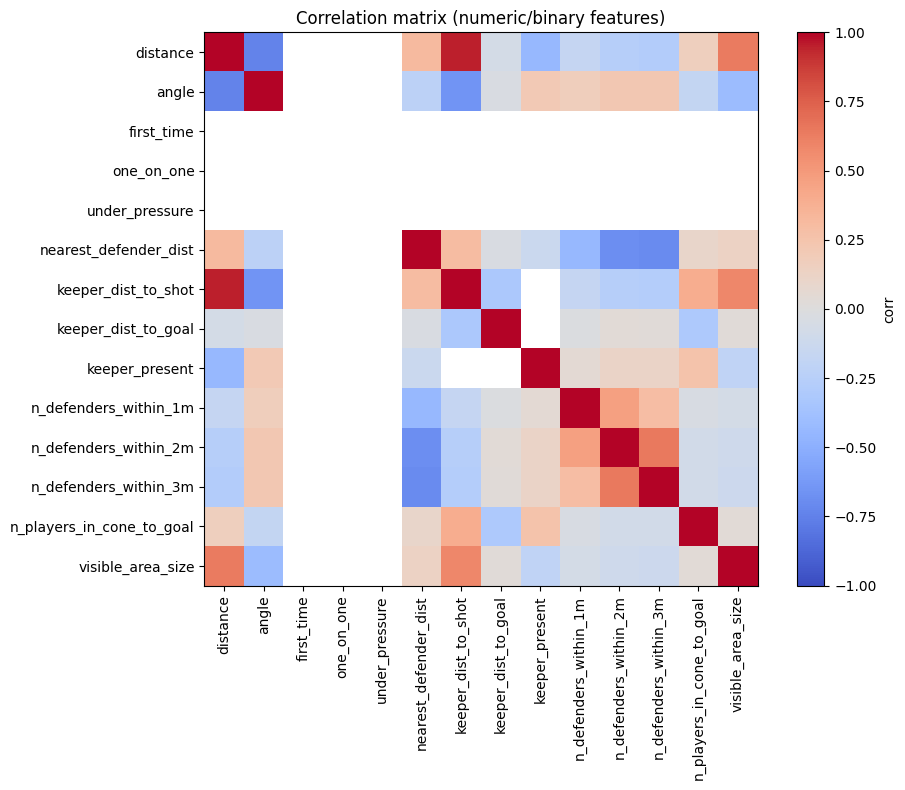

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Selezione feature numeriche/binarie
corr_cols = [
    "distance",
    "angle",
    "first_time",
    "one_on_one",
    "under_pressure",
    "nearest_defender_dist",
    "keeper_dist_to_shot",
    "keeper_dist_to_goal",
    "keeper_present",
    "n_defenders_within_1m",
    "n_defenders_within_2m",
    "n_defenders_within_3m",
    "n_players_in_cone_to_goal",
    "visible_area_size",
]

corr_df = shots_fe[corr_cols].copy()
# Cast booleane a float per correlazione
for col in ["first_time", "one_on_one", "under_pressure", "keeper_present"]:
    corr_df[col] = corr_df[col].astype(float)

corr = corr_df.corr()

plt.figure(figsize=(10, 8))
plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(label="corr")
plt.xticks(range(len(corr_cols)), corr_cols, rotation=90)
plt.yticks(range(len(corr_cols)), corr_cols)
plt.title("Correlation matrix (numeric/binary features)")
plt.tight_layout()
plt.show()


### 5.6 Feature importance preliminare (probe model)
Importanza preliminare con permutation importance su validation, prima del training finale.


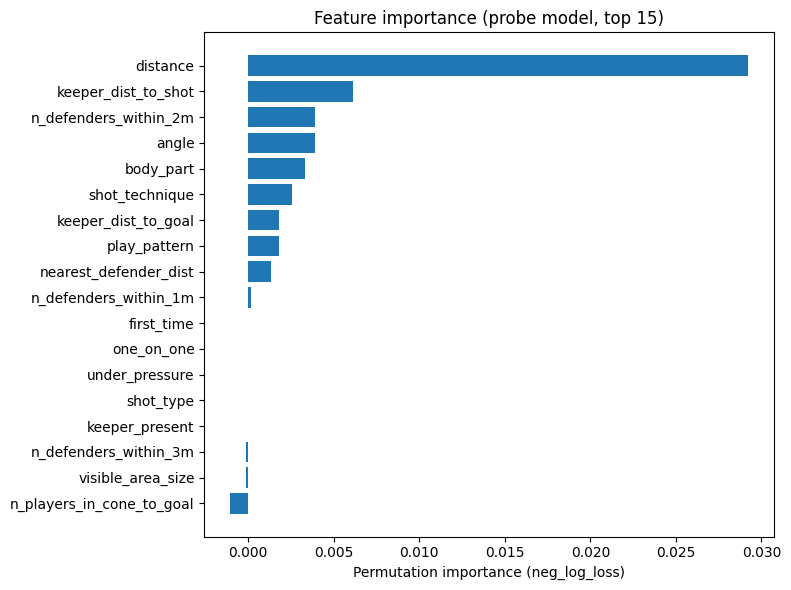

In [51]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance

# Feature set base + 360 (per probe)
base_num = ["distance", "angle"]
base_cat = ["body_part", "shot_type", "shot_technique", "play_pattern"]
base_bin = ["first_time", "one_on_one", "under_pressure"]
feat_360 = [
    "nearest_defender_dist",
    "keeper_dist_to_shot",
    "keeper_dist_to_goal",
    "keeper_present",
    "n_defenders_within_1m",
    "n_defenders_within_2m",
    "n_defenders_within_3m",
    "n_players_in_cone_to_goal",
    "visible_area_size",
]

def build_probe_model(num_cols, cat_cols, bin_cols):
    pre = ColumnTransformer(
        transformers=[
            ("num", Pipeline([
                ("imputer", SimpleImputer(strategy="median"))
            ]), num_cols + bin_cols),
            ("cat", Pipeline([
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("onehot", OneHotEncoder(handle_unknown="ignore"))
            ]), cat_cols),
        ],
        remainder="drop",
    )
    model = LogisticRegression(max_iter=1000, solver="liblinear")
    return Pipeline([
        ("pre", pre),
        ("model", model),
    ])

# Probe model su validation (richiede split già eseguito)
probe_model = build_probe_model(base_num + feat_360, base_cat, base_bin)
probe_model.fit(X_train, y_train)

cols_probe = base_num + feat_360 + base_bin + base_cat
X_val_probe = X_val[cols_probe]

perm = permutation_importance(
    probe_model,
    X_val_probe,
    y_val,
    n_repeats=10,
    random_state=42,
    scoring="neg_log_loss",
)

fi_probe = pd.DataFrame({
    "feature": cols_probe,
    "importance": perm.importances_mean,
}).sort_values("importance", ascending=False)

plt.figure(figsize=(8, 6))
plt.barh(fi_probe["feature"].head(25)[::-1], fi_probe["importance"].head(25)[::-1])
plt.title("Feature importance (probe model, top 15)")
plt.xlabel("Permutation importance (neg_log_loss)")
plt.tight_layout()
plt.show()


# 6) Creazione Split per match
Split train/valid/test a livello di `match_id` per evitare leakage.


In [34]:
from sklearn.model_selection import train_test_split

# Uso shots_fe (dataset finale con feature base + 360)
# In caso di valori mancanti, li gestiamo più avanti con imputazione.

# Match split
match_ids = shots_fe["match_id"].dropna().unique()
train_ids, test_ids = train_test_split(match_ids, test_size=0.2, random_state=42)
train_ids, val_ids = train_test_split(train_ids, test_size=0.2, random_state=42)

shots_train = shots_fe[shots_fe["match_id"].isin(train_ids)].copy()
shots_val = shots_fe[shots_fe["match_id"].isin(val_ids)].copy()
shots_test = shots_fe[shots_fe["match_id"].isin(test_ids)].copy()

print("train/val/test sizes:", shots_train.shape, shots_val.shape, shots_test.shape)


train/val/test sizes: (1995, 23) (525, 23) (639, 23)


### 6.1 Baseline → 360 uplift
Confronto un modello baseline (solo feature geometriche + meta) con un modello 360.
Metriche: log loss, Brier e AUC. Uplift = differenza metriche.


## 7) Training (Baseline vs 360)


### 7.1 Feature set + dataset
Definisco le colonne numeriche/categoriche/binarie e i dataset train/val/test.


In [35]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, brier_score_loss, roc_auc_score

# Feature set base (no 360)
base_num = ["distance", "angle"]
base_cat = ["body_part", "shot_type", "shot_technique", "play_pattern"]
base_bin = ["first_time", "one_on_one", "under_pressure"]

# Feature 360 add-on
feat_360 = [
    "nearest_defender_dist",
    "keeper_dist_to_shot",
    "keeper_dist_to_goal",
    "keeper_present",
    "n_defenders_within_1m",
    "n_defenders_within_2m",
    "n_defenders_within_3m",
    "n_players_in_cone_to_goal",
    "visible_area_size",
]

# Pipeline helper

def build_model(num_cols, cat_cols, bin_cols):
    pre = ColumnTransformer(
        transformers=[
            ("num", Pipeline([
                ("imputer", SimpleImputer(strategy="median"))
            ]), num_cols + bin_cols),
            ("cat", Pipeline([
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("onehot", OneHotEncoder(handle_unknown="ignore"))
            ]), cat_cols),
        ],
        remainder="drop",
    )

    model = LogisticRegression(max_iter=1000, solver="liblinear")
    return Pipeline([
        ("pre", pre),
        ("model", model),
    ])


# Dataset
X_train = shots_train
X_val = shots_val
X_test = shots_test

y_train = shots_train["goal"]
y_val = shots_val["goal"]
y_test = shots_test["goal"]


### 7.2 Training baseline
Alleno il modello base con feature geometriche + metadata.


In [36]:
# Baseline model
baseline_model = build_model(base_num, base_cat, base_bin)
baseline_model.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['distance', 'angle',
                                                   'first_time', 'one_on_one',
                                                   'under_pressure']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['body_part', 'shot_type',
                                                   'shot_technique',
                                                   'play_pattern'])])),
                ('model',
                 LogisticRegression(max_iter=1000, solver='liblinear'))])

### 7.3 Training 360
Alleno il modello completo con feature 360.


In [37]:
# 360 model = baseline + 360 features
all_num = base_num + feat_360
model_360 = build_model(all_num, base_cat, base_bin)
model_360.fit(X_train, y_train)


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['distance', 'angle',
                                                   'nearest_defender_dist',
                                                   'keeper_dist_to_shot',
                                                   'keeper_dist_to_goal',
                                                   'keeper_present',
                                                   'n_defenders_within_1m',
                                                   'n_defenders_within_2m',
                                                   'n_defenders_within_3m',
                                                   'n_players_in_cone_to_goal',
                                                   'visible_area_size',
                                                   'first_time', 'one_on_one',
                                                   'under_pressure']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['body_part', 'shot_type',
                                                   'shot_technique',
                                                   'play_pattern'])])),
                ('model',
                 LogisticRegression(max_iter=1000, solver='liblinear'))])

### 7.4 Uplift: metriche su validation e test
Confronto log loss, Brier e AUC per baseline vs 360.


In [38]:
# Metrics

def eval_model(model, X, y):
    proba = model.predict_proba(X)[:, 1]
    return {
        "log_loss": log_loss(y, proba),
        "brier": brier_score_loss(y, proba),
        "auc": roc_auc_score(y, proba),
    }

baseline_val = eval_model(baseline_model, X_val, y_val)
model_360_val = eval_model(model_360, X_val, y_val)

baseline_test = eval_model(baseline_model, X_test, y_test)
model_360_test = eval_model(model_360, X_test, y_test)

print("VAL baseline:", baseline_val)
print("VAL 360:", model_360_val)
print("TEST baseline:", baseline_test)
print("TEST 360:", model_360_test)


VAL baseline: {'log_loss': 0.2489463070732626, 'brier': np.float64(0.06902603390457825), 'auc': np.float64(0.7897845397845398)}
VAL 360: {'log_loss': 0.2485385211040135, 'brier': np.float64(0.06835328768143506), 'auc': np.float64(0.7784445284445284)}
TEST baseline: {'log_loss': 0.28905710091568976, 'brier': np.float64(0.08104314995156979), 'auc': np.float64(0.7287054409005629)}
TEST 360: {'log_loss': 0.2936844086369439, 'brier': np.float64(0.08353260215267307), 'auc': np.float64(0.7376842669525595)}


### 7.5 Feature importance post-training
Calcolo l'importanza delle feature sul modello finale (360) usando permutation importance su validation.


In [52]:
from sklearn.inspection import permutation_importance

# Feature importance post-training (modello 360)
cols_360 = base_num + feat_360 + base_bin + base_cat
X_val_360 = X_val[cols_360]

perm_post = permutation_importance(
    model_360,
    X_val_360,
    y_val,
    n_repeats=10,
    random_state=42,
    scoring="neg_log_loss",
)

fi_post = pd.DataFrame({
    "feature": cols_360,
    "importance": perm_post.importances_mean,
})
fi_post = fi_post.sort_values("importance", ascending=False)
fi_post.head(20)


,feature,importance
0,distance,0.029225
3,keeper_dist_to_shot,0.006109
7,n_defenders_within_2m,0.003905
1,angle,0.003888
14,body_part,0.003329
16,shot_technique,0.002556
4,keeper_dist_to_goal,0.001822
17,play_pattern,0.001802
2,nearest_defender_dist,0.001364
6,n_defenders_within_1m,0.000142


## 8) Validation
Analisi specifica di validazione: calibrazione e confronto curve baseline vs 360.


### 8.1 Calibration curve (validation)
Controllo se le probabilita sono calibrate.


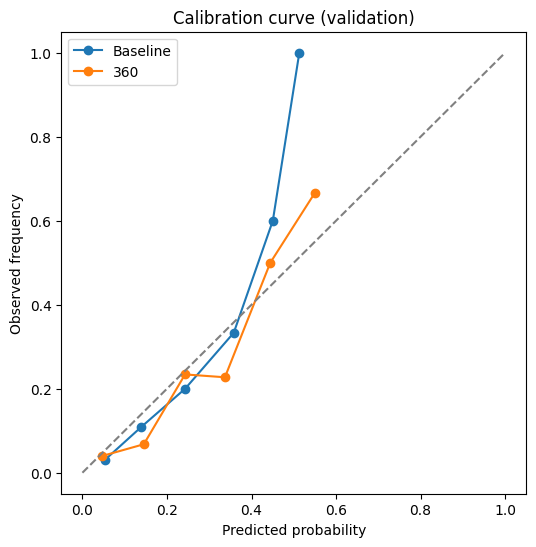

In [53]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Probabilita su validation
proba_base = baseline_model.predict_proba(X_val)[:, 1]
proba_360 = model_360.predict_proba(X_val)[:, 1]

frac_base, mean_base = calibration_curve(y_val, proba_base, n_bins=10)
frac_360, mean_360 = calibration_curve(y_val, proba_360, n_bins=10)

plt.figure(figsize=(6, 6))
plt.plot(mean_base, frac_base, marker='o', label='Baseline')
plt.plot(mean_360, frac_360, marker='o', label='360')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel('Predicted probability')
plt.ylabel('Observed frequency')
plt.title('Calibration curve (validation)')
plt.legend()
plt.show()
